# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

---
Week 7:

- Using a .random() value is equivalent to using a hash function for determining an index, if hashing is too slow. 
- MurmurHash is a non-cryptographic hash function library that is faster than a cryptographic hash library.


- **LSH w/ random hyperplanes:** Sicco - "You have some data points, then you have some planes that you draw, then for every plane you get a 0/1 classification whether or not a data point lies on which side of the hyperplane. Compute the labels for all datapoints, and then compute pairwise distances between data points that have that specific label. It can be compared against a full nearest-neighbor search to see performance/speed, but not required."

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

- Be sure to install the following: 
    - the python wrapper for murmurhash3: `pip install mmh3`
    - the NLP package for n-grams: `pip install nltk`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mmh3
import nltk as nl
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [2]:
df_10 = pd.read_csv("./dataset_10/capture20110818.binetflow")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek


In [3]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122199 entries, 0 to 122198
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Dur       122199 non-null  float64
 1   Proto     122199 non-null  object 
 2   SrcAddr   122199 non-null  object 
 3   Sport     122172 non-null  object 
 4   Dir       122199 non-null  object 
 5   DstAddr   122199 non-null  object 
 6   Dport     21003 non-null   object 
 7   State     120972 non-null  object 
 8   TotPkts   122199 non-null  int64  
 9   TotBytes  122199 non-null  int64  
 10  SrcBytes  122199 non-null  int64  
 11  Label     122199 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 11.2+ MB


## 1. Familiarization and discretization task – 1 A4

In [4]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [5]:
# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [6]:
# Remove hexadecimal values from the dataset
df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')

df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))

df_10.Dport

0           443
1            80
2            80
3            53
4            53
          ...  
122194    33822
122195    33822
122196       53
122197       53
122198       80
Name: Dport, Length: 122199, dtype: int64

In [7]:
# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
# df_10_inf.Metalabel.loc[np.where(df_10_inf.Label.str.contains('Normal'))] = 'Normal'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'

df_10


<ipython-input-7-bce7a68da95d>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill,NaN
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000743,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122195,0.000913,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122196,0.000414,udp,147.32.84.170,37138,<->,147.32.80.9,53,CON,2,244,81,flow=From-Normal-V51-Stribrek,NaN
122197,0.000322,udp,147.32.84.170,39771,<->,147.32.80.9,53,CON,2,280,81,flow=From-Normal-V51-Stribrek,NaN


In [8]:
# Identify the infected hosts:
inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].SrcAddr.unique()
inf

array(['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
       '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207',
       '147.32.84.208', '147.32.84.209'], dtype=object)

In [9]:
# see the activity level of each infected host
df_10.SrcAddr.loc[np.where(df_10.Label.str.contains('Botnet'))].value_counts()

147.32.84.205    11874
147.32.84.206    11287
147.32.84.204    11159
147.32.84.208    11118
147.32.84.207    10581
147.32.84.191    10454
147.32.84.192    10397
147.32.84.193    10009
147.32.84.209     9894
147.32.84.165     9579
Name: SrcAddr, dtype: int64

<BarContainer object of 10 artists>

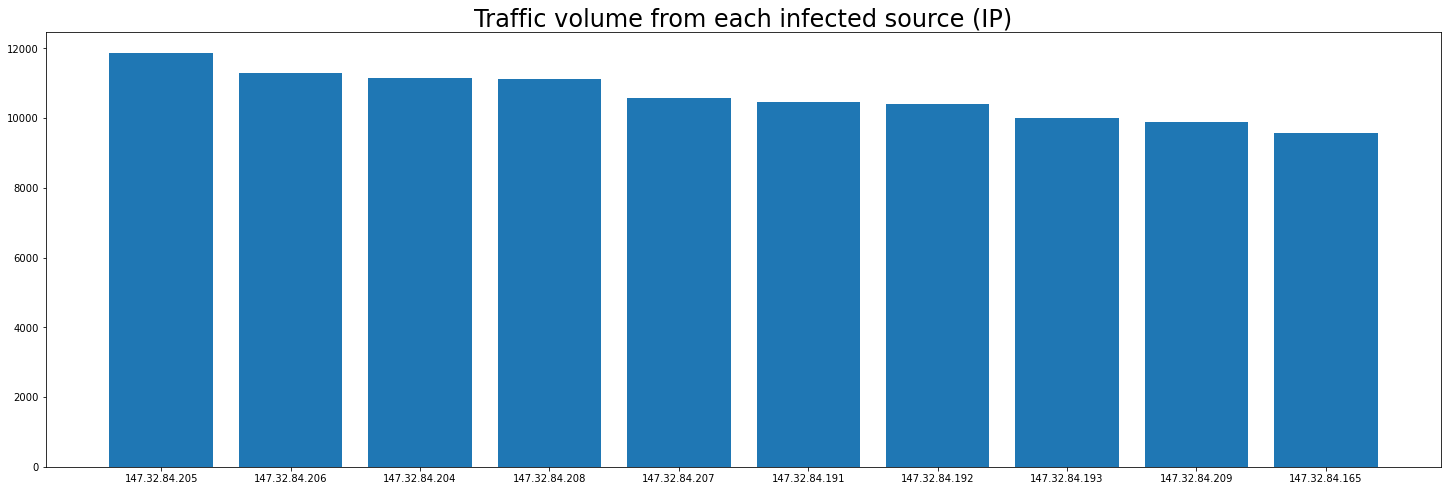

In [10]:
# visualization of amount of traffic from each infected source
fig = plt.figure(figsize=(25,8))
plt.title('Traffic volume from each infected source (IP)', size=24)
plt.bar(df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts().index,
        df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts())

In [11]:
# pick one of the hosts (we'll choose the one with the most traffic)
df_10_inf_1 = df_10.loc[df_10.SrcAddr == '147.32.84.205'].reset_index(inplace=False)
df_10_inf_1

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,1473,0.000263,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,203,64,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
1,1474,0.000401,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
2,1475,0.075763,tcp,147.32.84.205,1027,->,74.125.232.199,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
3,1478,0.000450,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
4,1479,3.017135,udp,147.32.84.205,123,->,65.55.56.40,123,INT,2,180,180,flow=From-Botnet-V51-6-UDP-Attempt,Botnet-UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11869,121650,367.653198,tcp,147.32.84.205,1026,->,216.155.130.130,6667,SPA_SPA,55,14273,1662,flow=From-Botnet-V51-6-TCP-CC106-IRC-Not-Encry...,Botnet-TCP
11870,121654,0.000455,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
11871,121655,0.044163,tcp,147.32.84.205,1028,->,74.125.232.202,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
11872,121656,0.000412,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP


In [12]:
df_10_inf_1.Proto.value_counts()

icmp    11836
udp        30
tcp         8
Name: Proto, dtype: int64

<BarContainer object of 3 artists>

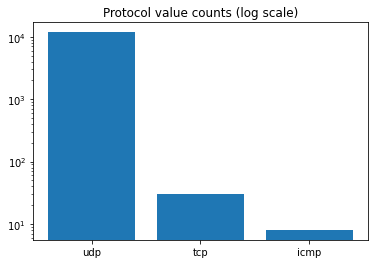

In [13]:
# Let's see what the frequency of each type of packet is
plt.yscale('log')
plt.title('Protocol value counts (log scale)')
plt.bar(df_10_inf_1.Proto.unique(), df_10_inf_1.Proto.value_counts())

<BarContainer object of 2 artists>

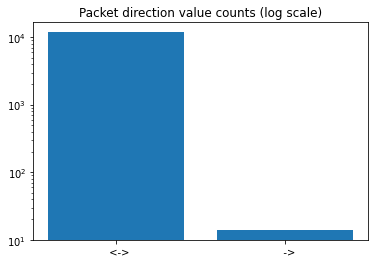

In [14]:
# frequency of each type of directional traffic
plt.yscale('log')
plt.title('Packet direction value counts (log scale)')
plt.bar(df_10_inf_1.Dir.unique(), df_10_inf_1.Dir.value_counts())

In [15]:
df_10_enc = df_10_inf_1.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)


In [16]:
print(df_10_enc.MetaLabel.value_counts().to_string())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8


In [17]:
df_10_enc['EncLabel'] = pd.Series()
# df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('Normal'))] = 0
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3

df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')
df_10_enc.EncLabel

<ipython-input-17-36a56fe13de3>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        2
1        2
2        3
3        2
4        2
        ..
11869    3
11870    2
11871    3
11872    2
11873    2
Name: EncLabel, Length: 11874, dtype: int8

In [18]:
# might not want to blindly encode these:
df_10_enc.Label = LabelEncoder().fit_transform(df_10_enc.Label)
print(df_10_enc.MetaLabel.value_counts())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8
Name: MetaLabel, dtype: int64


In [19]:
df_10_enc.head(10)

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel,EncLabel
0,1473,0.000263,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
1,1474,0.000401,2,0,53,1,0,190,1,1,6,4,5,Botnet-UDP,2
2,1475,0.075763,1,0,57,0,5,221,30,4,7,7,2,Botnet-TCP,3
3,1478,0.000450,2,0,53,1,0,190,1,1,4,2,5,Botnet-UDP,2
4,1479,3.017135,2,0,426,0,4,28,7,1,1,5,4,Botnet-UDP,2
5,1974,0.000465,2,0,53,1,0,190,1,1,5,2,5,Botnet-UDP,2
6,1975,3570.946045,1,0,68,0,9,205,28,51,33,12,1,Botnet-TCP,3
7,2492,0.000227,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
8,2497,0.000384,2,0,53,1,0,190,1,1,3,3,5,Botnet-UDP,2
9,2498,60.004951,1,0,72,0,2,221,30,5,9,6,3,Botnet-TCP,3


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

Text(0.5, 1.0, 'Correlation heat map')

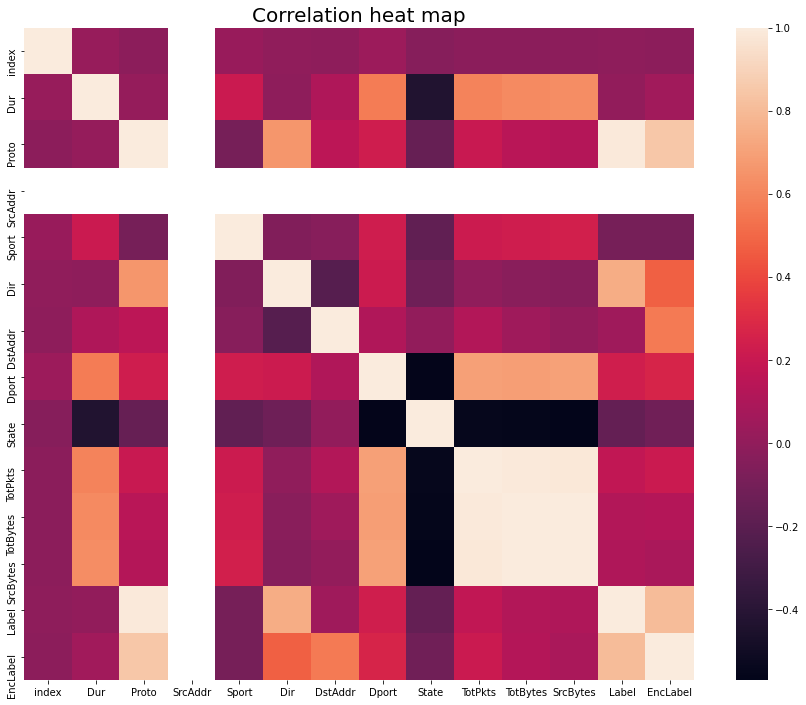

In [20]:
# Let's look at a correlation heatmap to see which are closely associated with target labels
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10_enc.corr())
plt.title('Correlation heat map', size=20)

Text(0.5, 1.0, 'Direction (blue) vs. Attack Type (yellow)')

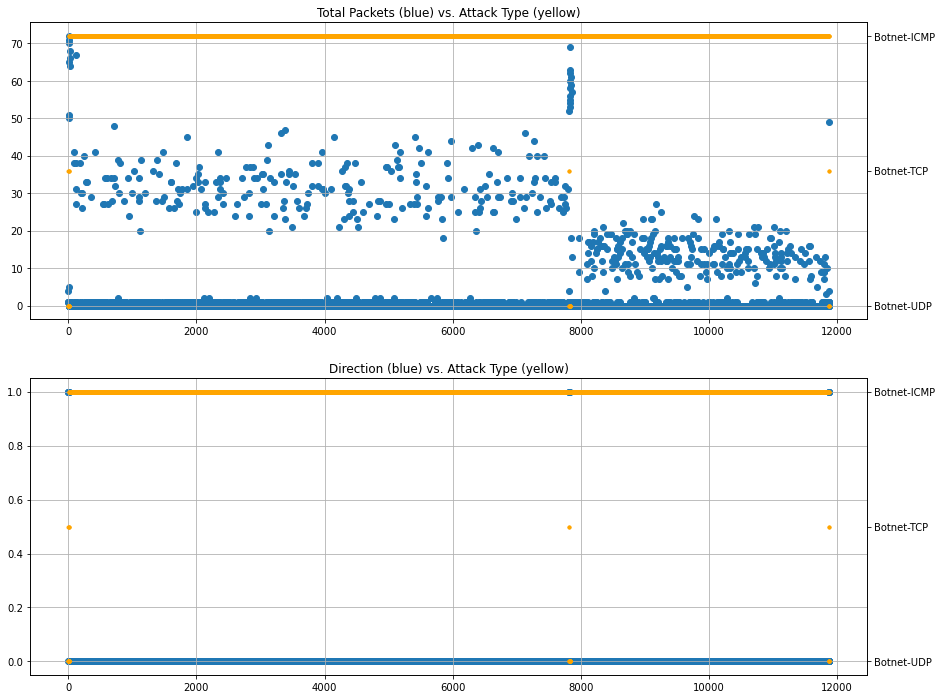

In [21]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))


ax1.scatter(df_10_enc.index, df_10_enc.TotPkts, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax1.scatter(df_10_enc.index, df_10_enc.TotBytes, marker=".", color='green', alpha=1)
# ax1.legend(['Dport'], loc='upper left')
# ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10_enc.index, df_10_enc.Dir, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax3.legend(['TotPkts'], loc='center left')
# ax4.legend(['Label'], loc='center right')

ax1.set_title('Total Packets (blue) vs. Attack Type (yellow)')
ax3.set_title('Direction (blue) vs. Attack Type (yellow)')



### 1b. Discretize selected features

As we see above, `Protocol` is most directly correlated with the encoded label. However, this is largely because `EncLabel` is a feature derived from `Protocol`, so we ignore it. Furthermore, the vast majority (>99%) of the values in `Proto` are `ICMP`, so the data is incredibly unbalanced.

The next highest correlation is `DstAddr`. Now, attackers can theoretically choose any target as a victim, so filtering destinations likely won't help us with a general model. 

Following that, the next highest correlation is `Dport`, but the vast majority of the dataset has been backfilled to `0` because most of the Dport values were `NaN`. This means that `Dir` and `TotPkts` are the next 2 most correlated features to the target labels.

Text(0.5, 1.0, 'Direction value counts (log scale)')

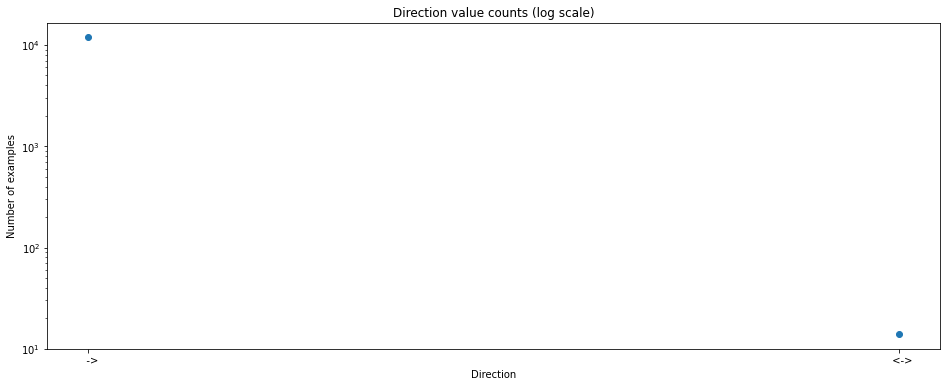

In [22]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# ax1 = plt.twinx()
plt.scatter(df_10_inf_1.Dir.value_counts().sort_index().index.values, df_10_inf_1.Dir.value_counts().sort_index())
# ax.scatter(df_10_enc.Dir.value_counts().sort_index().index.values, df_10_enc.Dir.value_counts().sort_index())
plt.ylabel('Number of examples')
plt.xlabel('Direction')
plt.title('Direction value counts (log scale)')

We see above that `DstAddr = 1` has far more attacks against it than any other port from this specific host.

Text(0.5, 1.0, 'Total number of packets value counts (log scale)')

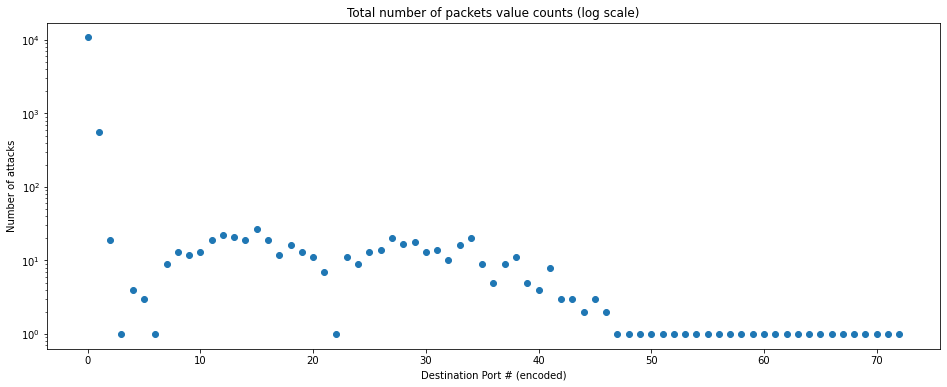

In [23]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# sorted_counts = np.sort(df_10_enc.Dport.value_counts().index)
plt.scatter(df_10_enc.TotPkts.value_counts().sort_index().index.values, df_10_enc.TotPkts.value_counts().sort_index())
plt.ylabel('Number of attacks')
plt.xlabel('Destination Port # (encoded)')
plt.title('Total number of packets value counts (log scale)')

Apply the discretization to the entire dataset:

In [24]:
# We can see that Dport and Dir are the two most outstanding features with the Metalabel w.r.t. botnet behavior
# Let's combine these with the encoded labels


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_x = pd.concat([df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)

df_10_x.DTP.value_counts()

<ipython-input-24-720fa04a273d>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


00      96238
01       4697
011       218
012       197
09        194
        ...  
0201        1
0161        1
0163        1
0203        1
057         1
Name: DTP, Length: 240, dtype: int64

In [25]:
# Let's bin the values into 3 categories:

# w = the most common value
w = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[0])])
z = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[1])])

y = df_10_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_10_x = pd.concat([w,x,y], sort=False).sort_index()
df_10_x

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DTP,MetaLabel,EncLabel
0,3,Botnet-UDP,2
1,3,Botnet-UDP,2
2,3,Botnet-TCP,3
3,3,Botnet-UDP,2
4,3,Botnet-UDP,2
...,...,...,...
106347,1,Botnet-ICMP,1
106348,3,Botnet-UDP,2
106349,3,Botnet-TCP,3
106350,3,Botnet-UDP,2


In [26]:
df_10_x.value_counts()

DTP  MetaLabel    EncLabel
1    Botnet-ICMP  1           96228
3    Botnet-ICMP  1            5080
2    Botnet-ICMP  1            4669
3    Botnet-UDP   2             255
     Botnet-TCP   3              82
2    Botnet-UDP   2              28
1    Botnet-UDP   2              10
dtype: int64

In [27]:
# really dirty way of creating n-grams, but I'll take it

gram = [int(str(df_10_x.DTP.iloc[0]) + str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2])),
         int(str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2]) + str(df_10_x.DTP.iloc[3]))]

ctr = 2
for item in df_10_x.DTP[2:]:

    gram.append(int(str(df_10_x.DTP.iloc[ctr - 2]) + str(df_10_x.DTP.iloc[ctr - 1]) + str(df_10_x.DTP.iloc[ctr])))
    ctr += 1

df_10_x['gram'] = gram

### 1b. Answers and explanation

Going off of correlation, many of the attributes with high correlation to attack labels are those that are difficult to generalize, e.g. `DstAddr` which are circumstantial, and `Dport` which was largely `NaN` and needed to be ignored. Therefore, we combined the attributes `Dir` and `TotPkts`, and binned them into three categories: `0`, `1`, and `2`.


## 2. Frequent task – 1/2 A4 (Individual)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

## 3. Sketching task – 1/2 A4 (Individual) (Andrew)

### 3a. COUNT-MIN sketch


In [82]:
# count-min sketch - w columns, d rows, k col index

class CountMinSketch:
    
    def __init__(self, w=None, d=None):
        if w is not None and d is not None:
            self.w = w
            self.d = d
            self.sketch = np.zeros(shape=(self.d, self.w), dtype=int) 

        else:
            raise Exception('You must provide parameters w (hash function range/number of columns) and d (number of hash functions/rows)')
            

    def create_sketch(self, data):
        
        # Loop over the "stream" of incoming data
        for i in data:
            # For each row/hash function in the sketch
            for j in range(self.d):
                
                # find the column k to increment for row j
                k = (mmh3.hash(str(i), j) % self.w)
                self.sketch[j][k] += 1
                
        return self.sketch
                
    
    def query_sketch(self, val):
    
        minimum = (2**32)-1
                
        # For each of the hash functions/rows
        for j in range(self.d):
            
            # Get the column k
            k = (mmh3.hash(str(val), j) % self.w)
            
            # Determine the global minimum across all rows
            minimum = np.minimum(minimum, self.sketch[j][k])

        return minimum

In [83]:
# Let's play with some w/d values to get some idea of how well it works:
DEBUG = False

# Define various ranges
w_ranges = [int(np.exp(1)/0.5), int(np.exp(1)/0.1), int(np.exp(1)/0.001),  int(np.exp(1)/0.0001)]
d_ranges = [int(np.log(1/0.01)), int(np.log(1/0.0001)), int(np.log(1/0.00001)), int(np.log(1/0.000001))]

# For the graphs later
dims = []
sizes = []
accuracies = []


for w in w_ranges:
    for d in d_ranges:
        
        sizes.append(w*d)
        dims.append(str((w, d)))
        
        # Define a new sketch for each w,d combo
        CMS = CountMinSketch(w, d)
        sketch = CMS.create_sketch(df_10_x.gram.values)
        
        # store the overcount discrepancy
        overcounts = []
        
        # Determine the true values vs. the estimated values
        for index, loc in zip(df_10_x.gram.value_counts().index.values, range(len(df_10_x.gram.value_counts().index.values))):
            true_val = df_10_x.gram.value_counts().iloc[loc]
            est_val = CMS.query_sketch(index)
            overcounts.append((est_val-true_val))
            
            if(DEBUG):
                print('True count of value:', index, ': ', true_val)
                print('True count of value:', index, ': ', est_val)    
                print('Discrepancy: ', est_val - true_val)
                print('Undercounted?', (est_val - true_val < 0)) # was checking to make sure CountMinSketch was working

        accuracies.append(sum(overcounts))
        
# find the average discrepancy per sketch
avg_disc = []
for i, j in zip(accuracies, sizes):
    avg_disc.append(i/j)

### 3b. Analysis and answers to the questions

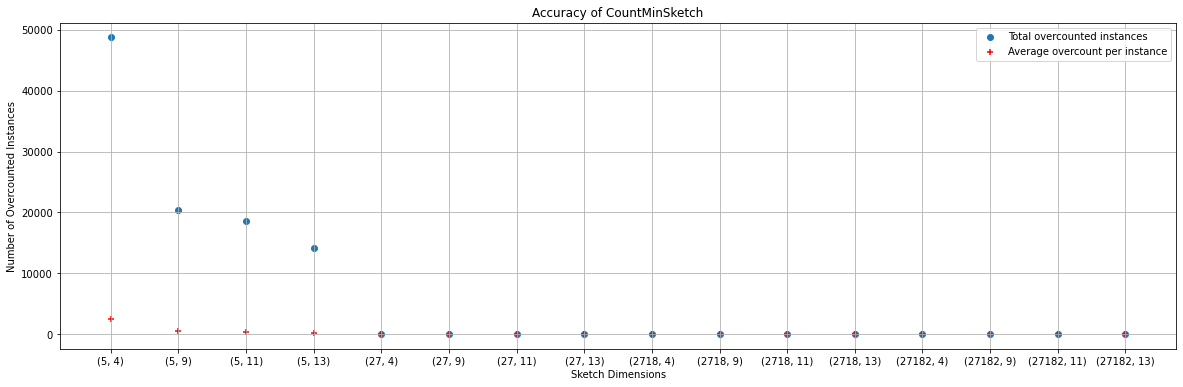

In [84]:
###
# What happens when you play with the w, d values (the dimensions of the sketch)
###


fig = plt.figure(figsize=(20,6))


plt.scatter(dims, accuracies, marker='o', alpha=1)

plt.scatter(dims, avg_disc, marker='+', color='r', alpha=1)
plt.grid()
plt.xlabel('Sketch Dimensions')
plt.ylabel('Number of Overcounted Instances')
plt.title('Accuracy of CountMinSketch')
plt.legend(['Total overcounted instances', 'Average overcount per instance'])

We can see above that there's a steep dropoff after the number of columns `w` starts to grow. Eventually, the sketch makes no mistakes and never overcounts.

In [85]:
###
# What are the 10 most frequent 3-grams and their frequencies when approximated?
###

print('The true counts of the 10 most frequent 3-grams:')
print(df_10_x.gram.value_counts()[:10])
print('---')
CMS_big = CountMinSketch(w=int(np.exp(1)/0.1), d=int(np.log(1/0.001)))
sketch_big = CMS_big.create_sketch(df_10_x.gram)

estimates = []
for item in df_10_x.gram.value_counts().index[:10].values:
    estimates.append((item, CMS_big.query_sketch(item)))

print('Estimate counts of the 10 most frequent 3-grams:')
print(estimates)

The true counts of the 10 most frequent 3-grams:
111    79369
131     4212
311     4184
113     4172
121     3836
112     3831
211     3819
333      287
313      265
133      256
Name: gram, dtype: int64
---
Estimate counts of the 10 most frequent 3-grams:
[(111, 79369), (131, 4212), (311, 4184), (113, 4172), (121, 3836), (112, 3831), (211, 3819), (333, 287), (313, 265), (133, 256)]


We can see from the results above that once we reach the dimensions of `w = e/0.1 = 27` and `d = log(1/0.001) = 6` we had 0 overcounts, meaning the true frequencies were identical to the approximated frequencies.

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual)

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual) (Andrew)

- Generate a vector of the occurences of a specific 3-gram.
    - Generate a random vector with random values (normal distribution?) and that's a hyperplane because it's perpendicular to some kind of line. Store those hyperplanes, don't do it repeatedly (5, 10, 20, k?)
    - Dot product for each random vector and the 3-gram vector:
        - provides a negative (encode as 0?) or positive value (encode as 1?)
    - Do this _ times, and concatenate each 0/1 value into a string of binary values (this is your "hash")
        - too few or too many hyperplanes is bad, choose a "sensible" value. Explain why. 
    - Compute pairwise distances for all, and those that are malicious hosts.

### 5a. Implementation - locality sensitive hashing

In [59]:
df_10_x

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,3,Botnet-UDP,2,333
1,0,3,Botnet-UDP,2,333
2,0,3,Botnet-TCP,3,333
3,0,3,Botnet-UDP,2,333
4,0,3,Botnet-UDP,2,333
...,...,...,...,...,...
106347,0,1,Botnet-ICMP,1,111
106348,7,3,Botnet-UDP,2,113
106349,7,3,Botnet-TCP,3,133
106350,0,3,Botnet-UDP,2,333


### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

In [50]:
# We need all the datasets

df_9 = pd.read_csv('./dataset_9/capture20110817.binetflow')


# Engineer the data for each (the same way we did for df_9)
df_9.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_9.drop(index=np.where(df_9['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_9.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_9.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_9.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_9.Dport = df_9.Dport.astype('str')
df_9.Sport = df_9.Sport.astype('str')
df_9.Dport = df_9.Dport.apply(lambda x: int(str(x), 0))
df_9.Sport = df_9.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_9['MetaLabel'] = pd.Series()
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_9_inf = df_9.loc[np.where(df_9.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_9_enc = df_9_inf.copy()
# df_9_enc.Dur = LabelEncoder().fit_transform(df_9_enc.Dur)
df_9_enc.Proto = LabelEncoder().fit_transform(df_9_enc.Proto)
df_9_enc.SrcAddr = LabelEncoder().fit_transform(df_9_enc.SrcAddr)
df_9_enc.Sport = LabelEncoder().fit_transform(df_9_enc.Sport.astype('str'))
df_9_enc.Dir = LabelEncoder().fit_transform(df_9_enc.Dir)
df_9_enc.DstAddr = LabelEncoder().fit_transform(df_9_enc.DstAddr.astype('str'))
df_9_enc.Dport = LabelEncoder().fit_transform(df_9_enc.Dport.astype('str'))
df_9_enc.State = LabelEncoder().fit_transform(df_9_enc.State.astype('str'))
df_9_enc.TotPkts = LabelEncoder().fit_transform(df_9_enc.TotPkts)
df_9_enc.TotBytes = LabelEncoder().fit_transform(df_9_enc.TotBytes)
df_9_enc.SrcBytes = LabelEncoder().fit_transform(df_9_enc.SrcBytes)

df_9_enc['EncLabel'] = pd.Series()
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('ICMP'))] = 1
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('UDP'))] = 2
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('TCP'))] = 3
df_9_enc.EncLabel = df_9_enc.EncLabel.astype('int8')


df_9_enc['DTP'] = df_9_enc.Dir.astype('str') + df_9_enc.TotPkts.astype('str')
df_9_x = pd.concat([df_9_enc.SrcAddr, df_9_enc.DTP, df_9_enc.MetaLabel, df_9_enc.EncLabel], axis=1)

# w = the most common value
w = df_9_x.iloc[pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP == df_9_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_9_x.iloc[pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP == df_9_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP != df_9_x.DTP.value_counts().index[0])])
z = pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP != df_9_x.DTP.value_counts().index[1])])

y = df_9_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_9_x = pd.concat([w,x,y], sort=False).sort_index()

# really dirty way of creating n-grams

grams = [int(str(df_9_x.DTP.iloc[0]) + str(df_9_x.DTP.iloc[1]) + str(df_9_x.DTP.iloc[2])),
         int(str(df_9_x.DTP.iloc[1]) + str(df_9_x.DTP.iloc[2]) + str(df_9_x.DTP.iloc[3]))]

ctr = 2
for item in df_9_x.DTP[2:]:

    grams.append(int(str(df_9_x.DTP.iloc[ctr - 2]) + str(df_9_x.DTP.iloc[ctr - 1]) + str(df_9_x.DTP.iloc[ctr])))
    ctr += 1

df_9_x['gram'] = grams

combos = sorted(df_9_x.gram.value_counts().index.values)





df_9_x

<ipython-input-50-cdb81a91dd1b>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-50-cdb81a91dd1b>:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,1,Botnet-UDP,2,113
1,0,1,Botnet-UDP,2,131
2,0,3,Botnet-TCP,3,113
3,0,1,Botnet-UDP,2,131
4,0,3,Botnet-UDP,2,313
...,...,...,...,...,...
184982,6,1,Botnet-UDP,2,211
184983,6,1,Botnet-UDP,2,111
184984,6,1,Botnet-UDP,2,111
184985,6,1,Botnet-UDP,2,111


In [51]:
# We need all the datasets

df_10 = pd.read_csv('./dataset_10/capture20110818.binetflow')

# Engineer the data for each (the same way we did for df_10)
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')
df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_x = pd.concat([df_10_enc.SrcAddr, df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)


# w = the most common value
w = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[0])])
z = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[1])])

y = df_10_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_10_x = pd.concat([w,x,y], sort=False).sort_index()

# really dirty way of creating n-grams

grams = [int(str(df_10_x.DTP.iloc[0]) + str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2])),
         int(str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2]) + str(df_10_x.DTP.iloc[3]))]

ctr = 2
for item in df_10_x.DTP[2:]:

    grams.append(int(str(df_10_x.DTP.iloc[ctr - 2]) + str(df_10_x.DTP.iloc[ctr - 1]) + str(df_10_x.DTP.iloc[ctr])))
    ctr += 1

df_10_x['gram'] = grams

combos = sorted(df_10_x.gram.value_counts().index.values)





df_10_x

<ipython-input-51-303869122d81>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-51-303869122d81>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,3,Botnet-UDP,2,333
1,0,3,Botnet-UDP,2,333
2,0,3,Botnet-TCP,3,333
3,0,3,Botnet-UDP,2,333
4,0,3,Botnet-UDP,2,333
...,...,...,...,...,...
106347,0,1,Botnet-ICMP,1,111
106348,7,3,Botnet-UDP,2,113
106349,7,3,Botnet-TCP,3,133
106350,0,3,Botnet-UDP,2,333


In [52]:
# We need all the datasets

df_11 = pd.read_csv('./dataset_11/capture20110818-2.binetflow')

# Engineer the data for each (the same way we did for df_11)
df_11.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_11.drop(index=np.where(df_11['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_11.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_11.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_11.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_11.Dport = df_11.Dport.astype('str')
df_11.Sport = df_11.Sport.astype('str')
df_11.Dport = df_11.Dport.apply(lambda x: int(str(x), 0))
df_11.Sport = df_11.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_11['MetaLabel'] = pd.Series()
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_11_inf = df_11.loc[np.where(df_11.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_11_enc = df_11_inf.copy()
# df_11_enc.Dur = LabelEncoder().fit_transform(df_11_enc.Dur)
df_11_enc.Proto = LabelEncoder().fit_transform(df_11_enc.Proto)
df_11_enc.SrcAddr = LabelEncoder().fit_transform(df_11_enc.SrcAddr)
df_11_enc.Sport = LabelEncoder().fit_transform(df_11_enc.Sport.astype('str'))
df_11_enc.Dir = LabelEncoder().fit_transform(df_11_enc.Dir)
df_11_enc.DstAddr = LabelEncoder().fit_transform(df_11_enc.DstAddr.astype('str'))
df_11_enc.Dport = LabelEncoder().fit_transform(df_11_enc.Dport.astype('str'))
df_11_enc.State = LabelEncoder().fit_transform(df_11_enc.State.astype('str'))
df_11_enc.TotPkts = LabelEncoder().fit_transform(df_11_enc.TotPkts)
df_11_enc.TotBytes = LabelEncoder().fit_transform(df_11_enc.TotBytes)
df_11_enc.SrcBytes = LabelEncoder().fit_transform(df_11_enc.SrcBytes)

df_11_enc['EncLabel'] = pd.Series()
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('ICMP'))] = 1
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('UDP'))] = 2
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('TCP'))] = 3
df_11_enc.EncLabel = df_11_enc.EncLabel.astype('int8')


df_11_enc['DTP'] = df_11_enc.Dir.astype('str') + df_11_enc.TotPkts.astype('str')
df_11_x = pd.concat([df_11_enc.SrcAddr, df_11_enc.DTP, df_11_enc.MetaLabel, df_11_enc.EncLabel], axis=1)



# w = the most common value
w = df_11_x.iloc[pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP == df_11_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_11_x.iloc[pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP == df_11_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP != df_11_x.DTP.value_counts().index[0])])
z = pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP != df_11_x.DTP.value_counts().index[1])])

y = df_11_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_11_x = pd.concat([w,x,y], sort=False).sort_index()



# really dirty way of creating n-grams

grams = [int(str(df_11_x.DTP.iloc[0]) + str(df_11_x.DTP.iloc[1]) + str(df_11_x.DTP.iloc[2])),
         int(str(df_11_x.DTP.iloc[1]) + str(df_11_x.DTP.iloc[2]) + str(df_11_x.DTP.iloc[3]))]

ctr = 2
for item in df_11_x.DTP[2:]:

    grams.append(int(str(df_11_x.DTP.iloc[ctr - 2]) + str(df_11_x.DTP.iloc[ctr - 1]) + str(df_11_x.DTP.iloc[ctr])))
    ctr += 1

df_11_x['gram'] = grams

combos = sorted(df_11_x.gram.value_counts().index.values)



df_11_x

<ipython-input-52-7d944ca8068b>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-52-7d944ca8068b>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,3,Botnet-UDP,2,333
1,0,3,Botnet-UDP,2,333
2,0,3,Botnet-TCP,3,333
3,0,3,Botnet-UDP,2,333
4,0,2,Botnet-UDP,2,332
...,...,...,...,...,...
8159,0,1,Botnet-ICMP,1,111
8160,0,1,Botnet-ICMP,1,111
8161,0,1,Botnet-ICMP,1,111
8162,0,1,Botnet-ICMP,1,111


In [53]:
# We need all the datasets

df_12 = pd.read_csv('./dataset_12/capture20110819.binetflow')

# Engineer the data for each (the same way we did for df_12)
df_12.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_12.drop(index=np.where(df_12['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_12.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_12.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_12.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_12.Dport = df_12.Dport.astype('str')
df_12.Sport = df_12.Sport.astype('str')
df_12.Dport = df_12.Dport.apply(lambda x: int(str(x), 0))
df_12.Sport = df_12.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_12['MetaLabel'] = pd.Series()
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_12_inf = df_12.loc[np.where(df_12.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_12_enc = df_12_inf.copy()
# df_12_enc.Dur = LabelEncoder().fit_transform(df_12_enc.Dur)
df_12_enc.Proto = LabelEncoder().fit_transform(df_12_enc.Proto)
df_12_enc.SrcAddr = LabelEncoder().fit_transform(df_12_enc.SrcAddr)
df_12_enc.Sport = LabelEncoder().fit_transform(df_12_enc.Sport.astype('str'))
df_12_enc.Dir = LabelEncoder().fit_transform(df_12_enc.Dir)
df_12_enc.DstAddr = LabelEncoder().fit_transform(df_12_enc.DstAddr.astype('str'))
df_12_enc.Dport = LabelEncoder().fit_transform(df_12_enc.Dport.astype('str'))
df_12_enc.State = LabelEncoder().fit_transform(df_12_enc.State.astype('str'))
df_12_enc.TotPkts = LabelEncoder().fit_transform(df_12_enc.TotPkts)
df_12_enc.TotBytes = LabelEncoder().fit_transform(df_12_enc.TotBytes)
df_12_enc.SrcBytes = LabelEncoder().fit_transform(df_12_enc.SrcBytes)

df_12_enc['EncLabel'] = pd.Series()
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('ICMP'))] = 1
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('UDP'))] = 2
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('TCP'))] = 3
df_12_enc.EncLabel = df_12_enc.EncLabel.astype('int8')


df_12_enc['DTP'] = df_12_enc.Dir.astype('str') + df_12_enc.TotPkts.astype('str')
df_12_x = pd.concat([df_12_enc.SrcAddr, df_12_enc.DTP, df_12_enc.MetaLabel, df_12_enc.EncLabel], axis=1)



# w = the most common value
w = df_12_x.iloc[pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP == df_12_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_12_x.iloc[pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP == df_12_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP != df_12_x.DTP.value_counts().index[0])])
z = pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP != df_12_x.DTP.value_counts().index[1])])

y = df_12_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_12_x = pd.concat([w,x,y], sort=False).sort_index()



# really dirty way of creating n-grams

grams = [int(str(df_12_x.DTP.iloc[0]) + str(df_12_x.DTP.iloc[1]) + str(df_12_x.DTP.iloc[2])),
         int(str(df_12_x.DTP.iloc[1]) + str(df_12_x.DTP.iloc[2]) + str(df_12_x.DTP.iloc[3]))]

ctr = 2
for item in df_12_x.DTP[2:]:

    grams.append(int(str(df_12_x.DTP.iloc[ctr - 2]) + str(df_12_x.DTP.iloc[ctr - 1]) + str(df_12_x.DTP.iloc[ctr])))
    ctr += 1

df_12_x['gram'] = grams

combos = sorted(df_12_x.gram.value_counts().index.values)


df_12_x

<ipython-input-53-00b6472b9e00>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-53-00b6472b9e00>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,1,Botnet-UDP,2,113
1,0,1,Botnet-UDP,2,131
2,0,3,Botnet-TCP,3,113
3,0,1,Botnet-UDP,2,131
4,0,3,Botnet-TCP,3,313
...,...,...,...,...,...
2163,0,1,Botnet-UDP,2,131
2164,0,3,Botnet-UDP,2,313
2165,1,2,Botnet-UDP,2,132
2166,0,1,Botnet-UDP,2,321


In [54]:
df_x = pd.concat([df_9_x, df_10_x, df_11_x, df_12_x], axis=0, ignore_index=True).sort_index()
df_x

,SrcAddr,DTP,MetaLabel,EncLabel,gram
0,0,1,Botnet-UDP,2,113
1,0,1,Botnet-UDP,2,131
2,0,3,Botnet-TCP,3,113
3,0,1,Botnet-UDP,2,131
4,0,3,Botnet-UDP,2,313
...,...,...,...,...,...
301666,0,1,Botnet-UDP,2,131
301667,0,3,Botnet-UDP,2,313
301668,1,2,Botnet-UDP,2,132
301669,0,1,Botnet-UDP,2,321


In [55]:
# We can see the distribution of our discretized DDTP values, some of which are significantly higher in numerical value
df_x.DTP.value_counts()

1    209692
3     63341
2     28638
Name: DTP, dtype: int64

In [56]:
df_x.gram.value_counts()

111    134204
113     21024
311     19697
131     16010
211     11360
112     10035
333     10012
133      9999
331      9144
121      8579
313      6820
321      5112
132      4755
332      4327
323      4194
231      3708
123      3541
233      3471
213      2920
312      2343
232      1918
221      1876
322      1694
122      1544
223      1362
212      1287
222       735
Name: gram, dtype: int64

In [57]:
df_x.to_csv('C:/Users/awrgo/Documents/Delft/CDA_2021/Labs/Lab 3/df_x_disc.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/awrgo/Documents/Delft/CDA_2021/Labs/Lab 3/df_x_disc.csv'

Notes:

- Include all hosts, even non-bots
- Take one botnet host (random?), convert n-grams to a vector for that host, and binarize: 0 if n-gram doesn't appear, 1 if so.
    - Do for all
    - Compare each vector to the botnet vector
    - Create some threshold for classification based on the distance
- Group by host
    - Drop any hosts with small number of examples
    - Create the n-grams
    - Look for n-grams that appear in botnet, but not in benign (something like this?)
    

In [ ]:
df_x.SrcAddr.value_counts()

In [ ]:
# Let's use the Elbow method to determine the optimal number of clusters. We see that the "elbow" is somewhere around 4

from sklearn.cluster import KMeans

X = df_x.drop('MetaLabel', axis=1, inplace=False)
distortions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distortions)
plt.grid()
plt.title('Elbow curve')

In [ ]:
df_x.DTP.value_counts()

In [ ]:
# Let's bin these into the top K categories based on the above elbow method

# a is for all DTP values = 00
a = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '00')]).index]
# b is for all DTP values == 11
b = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '11')]).index]
# c is for all DTP values == 02
c = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '02')]).index]
# d is for all DTP values == 01
d = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '01')]).index]


e = df_x.DTP.loc[np.where(df_x.DTP != '00')].index
f = df_x.DTP.loc[np.where(df_x.DTP != '11')].index
g = df_x.DTP.loc[np.where(df_x.DTP != '02')].index
h = df_x.DTP.loc[np.where(df_x.DTP != '01')].index


i = e.intersection(f)
j = f.intersection(g)
k = g.intersection(h)

l = df_x.iloc[k]


a.DTP = 0
b.DTP = 1
c.DTP = 2
d.DTP = 3
l.DTP = 4
 
df_fin = pd.concat([a,b,c,d,l], axis=0, sort=False).sort_index()

In [ ]:
# A bit more balanced
df_fin.DTP.value_counts()

### 6a. Learn a sequential model

In [ ]:
# We can see below that there's a dramatic shift when the botnet starts receiving ICMP packets. 
fig, ax = plt.subplots(figsize=(20,15))

df_fin['DTP_1000'] = pd.Series(df_fin.DTP.rolling(window=1000).mean()).fillna(method='bfill')
ax1 = ax.twinx()
ax1.grid()
ax.plot(df_fin.DTP)
ax.plot(df_fin.DTP_1000)

ax1.scatter(df_fin.index, df_fin.MetaLabel, color='red')
ax1.legend(['Attack Type'])

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

Be creative?

### 8a. Provide implementation and analysis.